In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import h5py
import timm
import torch
import torch.nn as nn
import torchaudio
import torchvision.transforms as TF
from PIL import Image as Img
import os
import random

from scipy.signal import wiener

from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler

device = torch.device('cuda')

### !!! Change the sigmoid in evaluating too
criterion = nn.BCEWithLogitsLoss()
msecriterion = nn.MSELoss()

df = pd.read_csv('./train_labels.csv')
df = df[df.target >= 0]  # Remove 3 unknowns (target = -1)
df["source"] = "trainlabels"

In [2]:

# for folder in ["./full_sig_json", "./new_sig_json", "./new_sig_json2", 
#                "./new_sig_json3", "./new_sig_json4", "./new_sig_json5",
#               "./new_sig_bands2", "./new_sig_bands3",
#               "./new_sig_bands_weak",
#               "./better_bands", "./better_bands_symetric", "./better_bands_symetric2",
#               "./better_bands_symetric3", "better_nobands_symetric", "symetric_line_writer",
#               "symetric_line_writer2", "weak_lines_symmetric",
#               "weak_noise_symmetric", "weak_bands_symmetric", \
#               "prev_eval_dataset", "eval_dataset2"]:
    
for folder in ["./eval_dataset2"]:
               
    for f in os.listdir(folder):
        if f == ".ipynb_checkpoints" or f == ".DS_Store":
            continue
        h0 = float(f.split("_")[2])
        if h0 < 10:
            continue
        
        df = df.append({"id": folder + "/" + f, "target": f.split(".")[-3].split("_")[-1], "source": "npy"}, ignore_index=True)
print("DONE")


DONE


In [3]:
len(df)

1200

In [4]:
folder = "./eval_dataset3"
for f in os.listdir(folder):
    if f == ".ipynb_checkpoints" or f == ".DS_Store":
        continue
    h0 = float(f.split("_")[2])
    if h0 < 10:
        continue

    df = df.append({"id": folder + "/" + f, "target": f.split(".")[-3].split("_")[-1], "source": "eval"}, ignore_index=True)
print("DONE")


DONE


In [5]:
len(df[df["source"] == "eval"])

600

In [6]:
# len(df[df["source"] != "trainlabels"])

In [7]:
# bestsub = pd.read_csv("./sub748_plus_5fold.csv")

In [8]:
# len(bestsub[bestsub["target"] < 0.12])

In [9]:
# for rowi, row in bestsub.iterrows():
#     if row["target"] > 0.95: # could be 0.9
#         df = df.append({"id": row["id"], 
#                         "target": 1, 
#                         "source": "test"}, ignore_index=True)
#     if row["target"] < 0.12: # coult be 0.15
#         df = df.append({"id": row["id"], 
#                         "target": 0, 
#                         "source": "test"}, ignore_index=True)

In [2]:
transforms_time_mask = nn.Sequential(
                torchaudio.transforms.TimeMasking(time_mask_param=10),
            )

transforms_freq_mask = nn.Sequential(
                torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
            )


flip_rate = 0.0 # probability of applying the horizontal flip and vertical flip 
fre_shift_rate = 0.0 # probability of applying the vertical shift

time_mask_num = 0 # number of time masking
freq_mask_num = 0 # number of frequency masking


In [3]:
# timm.list_models()

In [4]:
# for n in timm.list_models(pretrained=True):
#     if "efficientnet" in n:
#         print(n)


In [5]:
        
IMGSIZE = 720
MAXSIZE = 6000


class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, data_type, df, tfms=False):
        self.data_type = data_type
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)
    
    def get_npy(self, row):
        data = np.load(f"{row.id}")

        img = np.zeros((2, 360, IMGSIZE), dtype=np.float32)

        across = int(data.shape[2] / IMGSIZE)
        across = min(across, int(MAXSIZE / IMGSIZE))

        areal = data[0,:,:(across*IMGSIZE)]**2
        aimag = data[1,:,:(across*IMGSIZE)]**2
        p = areal + aimag  # power
        p /= np.mean(p)  # normalize
#         p = wiener(p, (3, 13))
        p = np.mean(p.reshape(360, IMGSIZE, across), axis=2)
        img[0] = p

        areal = data[2,:,:(across*IMGSIZE)]**2
        aimag = data[3,:,:(across*IMGSIZE)]**2
        p = areal + aimag  # power
        p /= np.mean(p)  # normalize
#         p = wiener(p, (3, 13))
        p = np.mean(p.reshape(360, IMGSIZE, across), axis=2)
        img[1] = p
        return img
    
    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        
        if "source" in self.df.columns and (r.source == "npy" or r.source == "eval" or r.source == "unused"):
            img = self.get_npy(r)
            freq = float(r.id.split("/")[-1].split("_")[1])
        else:
            file_id = r.id
            img = np.empty((2, 360, IMGSIZE), dtype=np.float32)
            
            if "source" in self.df.columns and r.source == "test":
                filename = '%s/%s.hdf5' % ("test", file_id)
            else:
                filename = '%s/%s.hdf5' % (self.data_type, file_id)
                
            with h5py.File(filename, 'r') as f:
                g = f[file_id]
                freq = g["frequency_Hz"][0]

                h1raw = g["H1"]['SFTs']
                h1across = int(h1raw.shape[1] / IMGSIZE)
                l1raw = g["L1"]['SFTs']
                l1across = int(l1raw.shape[1] / IMGSIZE)
                across = min(h1across, l1across)
                across = min(across, int(MAXSIZE / IMGSIZE))

                for ch, s in enumerate(['H1', 'L1']):
                    a = g[s]['SFTs'][:, :(across*IMGSIZE)] * 1e22  # Fourier coefficient complex64

                    areal = a.real**2
                    aimag = a.imag**2
                    p = areal + aimag  # power
                    p /= np.mean(p)  # normalize
#                     p = wiener(p, (3, 13))
                    
                    p = np.mean(p.reshape(360, IMGSIZE, across), axis=2)  # compress 4096 -> 128
                    img[ch] = p

    
        mean0 = img[0].mean()
        std0 = img[0].std()
        mean1 = img[1].mean()
        std1 = img[1].std()
        
        if self.tfms:            
            if np.random.rand() <= flip_rate: # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= flip_rate: # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= fre_shift_rate: # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
            img = torch.from_numpy(img)

            for _ in range(time_mask_num): # tima masking
                img = transforms_time_mask(img)
            for _ in range(freq_mask_num): # frequency masking
                img = transforms_freq_mask(img)
        
        else:
            img = torch.from_numpy(img)
        

        img = img - img.mean()
        img = img / img.std()
        
        
        return img.float(), torch.FloatTensor([freq]), \
            torch.FloatTensor([mean0]), torch.FloatTensor([std0]), \
                torch.FloatTensor([mean1]), torch.FloatTensor([std1]),  y
    

In [6]:
dataset = Dataset('train', df, tfms=True)
img, freq, mean0, std0, mean1, std1, y = dataset.__getitem__(0)
img, freq, mean0, std0, mean1, std1, y = dataset.__getitem__(700)
freq

IndexError: single positional indexer is out-of-bounds

In [7]:
img.shape

torch.Size([2, 360, 720])

In [8]:

class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        self.premodel = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=(3,31), stride=(1,2), padding=(3//2,31//2)),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=(5,5), stride=(1,2), padding=(5//2,5//2)),
            nn.GELU(),
        )
        torch.nn.init.xavier_uniform_(self.premodel[0].weight)
        torch.nn.init.xavier_uniform_(self.premodel[2].weight)
#         torch.nn.init.xavier_uniform_(self.premodel[4].weight)
        
        # Use timm
        model = timm.create_model(name, pretrained=pretrained, \
                                  in_chans=128, drop_rate=0.0)

        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()

        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)
        self.drop3 = nn.Dropout(0.3)
        self.drop4 = nn.Dropout(0.4)
        self.drop5 = nn.Dropout(0.5)
        self.drop6 = nn.Dropout(0.1)
        self.drop7 = nn.Dropout(0.2)
        self.drop8 = nn.Dropout(0.3)
        self.drop9 = nn.Dropout(0.4)
        self.drop10 = nn.Dropout(0.5)
        
        self.fc = nn.Sequential(
            nn.Linear(n_features+3, 512),
            nn.GELU(),
            nn.Linear(512,256),
            nn.GELU(),
            nn.Linear(256,2)
        )
        self.model = model
        
        torch.nn.init.xavier_uniform_(self.fc[0].weight)
        torch.nn.init.xavier_uniform_(self.fc[2].weight)
        torch.nn.init.xavier_uniform_(self.fc[4].weight)
        
    def forward(self, x, freq, mean0, std0, mean1, std1):
        
        x = self.premodel(x)
        x = self.model(x)
        
        x1 = self.drop1(x)
        x2 = self.drop2(x)
        x3 = self.drop3(x)
        x4 = self.drop4(x)
        x5 = self.drop5(x)
        x6 = self.drop6(x)
        x7 = self.drop7(x)
        x8 = self.drop8(x)
        x9 = self.drop9(x)
        x10 = self.drop10(x)

        x1 = torch.cat((x1, freq/500.0, std0, std1), dim=1)
        x2 = torch.cat((x2, freq/500.0, std0, std1), dim=1)
        x3 = torch.cat((x3, freq/500.0, std0, std1), dim=1)
        x4 = torch.cat((x4, freq/500.0, std0, std1), dim=1)
        x5 = torch.cat((x5, freq/500.0, std0, std1), dim=1)
        x6 = torch.cat((x6, freq/500.0, std0, std1), dim=1)
        x7 = torch.cat((x7, freq/500.0, std0, std1), dim=1)
        x8 = torch.cat((x8, freq/500.0, std0, std1), dim=1)
        x9 = torch.cat((x9, freq/500.0, std0, std1), dim=1)
        x10 = torch.cat((x10, freq/500.0, std0, std1), dim=1)
        
        x1 = self.fc(x1)
        x2 = self.fc(x2)
        x3 = self.fc(x3)
        x4 = self.fc(x4)
        x5 = self.fc(x5)
        x6 = self.fc(x6)
        x7 = self.fc(x7)
        x8 = self.fc(x8)
        x9 = self.fc(x9)
        x10 = self.fc(x10)
        
        return((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10))
    
#         x = self.fc(x)
#         return x


In [9]:
def evaluate(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)

    for img, freq, mean0, std0, mean1, std1, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)
        freq = freq.to(device)
        mean0 = mean0.to(device)
        std0 = std0.to(device)
        mean1 = mean1.to(device)
        std1 = std1.to(device)

        with torch.no_grad():
#             y_pred = model(img, freq)
            y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred7,y_pred8,y_pred9,y_pred10 = model(img, freq, mean0, std0, mean1, std1)        
            y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6 + y_pred7 + y_pred8 + y_pred9 + y_pred10) / 10.0
        
        loss = criterion(y_pred[:,0].view(-1), y) + msecriterion(y_pred[:,1].view(-1).sigmoid(), y)

        n_sum += n
        loss_sum += n * loss.item()

        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred[:,0].sigmoid().squeeze().cpu().detach().numpy())
#         y_pred_all.append(y_pred.squeeze().cpu().detach().numpy())

        if pbar is not None:
            pbar.update(len(img))
        
        del loss, y_pred, img, y

    loss_val = loss_sum / n_sum

    if compute_score:
        if y_pred_all[0].size != y_pred_all[-1].size:
            y_pred_all = y_pred_all[:-2]
            y_all = y_all[:-2]
    
    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    score = roc_auc_score(y, y_pred) if compute_score else None

    ret = {'loss': loss_val,
           'score': score,
           'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary

    return ret

In [20]:
model_name = 'tf_efficientnet_b7_ns'
# model_name = 'tf_efficientnetv2_b0'

nfold = 5
kfold = KFold(n_splits=nfold, random_state=42, shuffle=True)

epochs = 25
batch_size = 8
num_workers = 2
weight_decay = 5e-6
max_grad_norm = 1000

lr_max = 7e-4
# lr_max = 1e-3
epochs_warmup = 1.0


## setting of audio data augmentation 
flip_rate = 0.5 # probability of applying the horizontal flip and vertical flip 
fre_shift_rate = 1.0 # probability of applying the vertical shift
time_mask_num = 1 # number of time masking
freq_mask_num = 2 # number of frequency masking

grad_accum = 18

allfolds = list(kfold.split(df))

results = []

for ifold, (idx_train, idx_test) in enumerate(allfolds):
    if ifold != 0:
        continue
        
    print('Fold %d/%d' % (ifold, nfold))

#     dataset_train = Dataset('train', df.loc[~df.index.isin(idx_test)], tfms=True)
#     dataset_train = Dataset('train', df.loc[df["source"] != "trainlabels"], tfms=True)

#     dataset_train = Dataset('train', df.iloc[idx_train], tfms=True)
#     dataset_val = Dataset('train', df.iloc[idx_test])

    dataset_train = Dataset('train', df.loc[df["source"] != "eval"], tfms=True)
    dataset_val = Dataset('train', df.loc[df["source"] == "eval"], tfms=False)

    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True, shuffle=True, drop_last=True)
    loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True)

    # Model and optimizer
    model = Model(model_name, pretrained=True)
    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)

    # Learning-rate schedule
    nbatch = len(loader_train)
    warmup = epochs_warmup * nbatch  # number of warmup steps
    nsteps = epochs * nbatch        # number of total steps

    scheduler = CosineLRScheduler(optimizer,
                  warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 epoch of warmup
                  t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine
    
    time_val = 0.0
    lrs = []
    
    minloss = 1.0
    
    tb = time.time()
    print('Epoch   loss          score   lr')
    for iepoch in range(epochs):
        loss_sum = 0.0
        n_sum = 0

        optimizer.zero_grad()
        # Train
        for ibatch, (img, freq, mean0, std0, mean1, std1, y) in enumerate(loader_train):
            n = y.size(0)
            img = img.to(device)
            y = y.to(device)
            freq = freq.to(device)
            mean0 = mean0.to(device)
            std0 = std0.to(device)
            mean1 = mean1.to(device)
            std1 = std1.to(device)

#             y_pred = model(img, freq)
            
            y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred7,y_pred8,y_pred9,y_pred10 = model(img, freq, mean0, std0, mean1, std1)        
            y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6 + y_pred7 + y_pred8 + y_pred9 + y_pred10) / 10.0
            
#             loss = criterion(y_pred.view(-1), y)
            loss = criterion(y_pred[:,0].view(-1), y) + msecriterion(y_pred[:,1].view(-1), y)

#             loss2 = msecriterion(y_pred.sigmoid().view(-1), y) * 2
#             loss = loss + loss2

            loss_train = loss.item()
            loss_sum += n * loss_train
            n_sum += n

            loss.backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                       max_grad_norm)
            
            if ibatch % grad_accum == 0 or len(loader_train) == (ibatch - 1):
                optimizer.step()
                optimizer.zero_grad()
            
            scheduler.step(iepoch * nbatch + ibatch + 1)
            lrs.append(optimizer.param_groups[0]['lr'])            

        # Evaluate
        val = evaluate(model, loader_val)
        time_val += val['time']
        loss_train = loss_sum / n_sum
        lr_now = optimizer.param_groups[0]['lr']
        dt = (time.time() - tb) / 60
        results.append('Epoch %d %.4f %.4f %.4f  %.2e  %.2f min' %
              (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))
        print('Epoch %d %.4f %.4f %.4f  %.2e  %.2f min' %
              (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))
        if val["loss"] < minloss:
            minloss = val["loss"]
            print("=== SAVING", val["loss"], val["score"])
            
            ofilename = 'model%d.pytorch' % ifold
            torch.save(model.state_dict(), ofilename)

    dt = time.time() - tb
    print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))

    # Save model
    ofilename = 'model%d_final.pytorch' % ifold
    torch.save(model.state_dict(), ofilename)
    print(ofilename, 'written')

    break  # 1 fold only

Fold 0/5
Epoch   loss          score   lr
Epoch 1 0.9027 0.8483 0.6642  7.00e-04  7.23 min
=== SAVING 0.8482852705319722 0.6641555555555556
Epoch 2 0.7667 0.9052 0.6816  6.97e-04  14.49 min
Epoch 3 0.7327 0.7960 0.7015  6.88e-04  21.76 min
=== SAVING 0.7959555145104726 0.7014777777777779
Epoch 4 0.7162 0.8162 0.6899  6.73e-04  29.03 min
Epoch 5 0.7083 0.8047 0.6719  6.53e-04  36.29 min
Epoch 6 0.7029 0.7941 0.6890  6.28e-04  43.54 min
=== SAVING 0.7940583829085032 0.689
Epoch 7 0.6897 0.7944 0.6960  5.98e-04  50.81 min
Epoch 8 0.6897 0.7897 0.6912  5.63e-04  58.08 min
=== SAVING 0.7897221251328786 0.6912222222222222
Epoch 9 0.6760 0.7893 0.7270  5.25e-04  65.37 min
=== SAVING 0.7893160235881805 0.7270444444444444
Epoch 10 0.6743 0.7838 0.7133  4.84e-04  72.65 min
=== SAVING 0.7837950388590494 0.7133
Epoch 11 0.6692 0.7864 0.7125  4.41e-04  79.92 min
Epoch 12 0.6693 0.7942 0.7035  3.96e-04  87.19 min
Epoch 13 0.6601 0.7833 0.7139  3.51e-04  94.46 min
=== SAVING 0.7833441150188446 0.7139

In [ ]:
### 16 bce mse, b7 model eval3, LB :0.754
# 0.6372 0.7726 0.7208
# 0.6211 0.7770 0.7305

### 15 bce mse, b0 model eval3, LB 0.747:
# 0.6551 0.7912 0.7320
# 0.6528 0.7933 0.7293

# Epoch 1 0.9498 0.8798 0.6291  7.00e-04  4.27 min
# === SAVING 0.8797697163209682 0.6291428670636643
# Epoch 2 0.8044 0.8441 0.6722  6.97e-04  8.60 min
# === SAVING 0.8441182845007114 0.6722338929495303
# Epoch 3 0.7639 0.8484 0.6641  6.88e-04  12.85 min
# Epoch 4 0.7481 0.8710 0.6652  6.73e-04  17.25 min
# Epoch 5 0.7322 0.8221 0.6881  6.53e-04  21.42 min
# === SAVING 0.8220611805838298 0.6881369468219933
# Epoch 6 0.7244 0.8411 0.6943  6.28e-04  25.50 min
# Epoch 7 0.7172 0.8064 0.6902  5.98e-04  29.76 min
# === SAVING 0.8064443028070093 0.6901682320873627
# Epoch 8 0.7073 0.8143 0.6760  5.63e-04  33.84 min
# Epoch 9 0.7037 0.8371 0.6946  5.25e-04  38.09 min
# Epoch 10 0.6963 0.8203 0.7020  4.84e-04  42.30 min
# Epoch 11 0.6934 0.8110 0.7011  4.41e-04  46.58 min
# Epoch 12 0.6885 0.8189 0.6972  3.96e-04  50.85 min
# Epoch 13 0.6878 0.8069 0.7241  3.51e-04  55.03 min
# Epoch 14 0.6846 0.8137 0.7091  3.05e-04  59.28 min
# Epoch 15 0.6770 0.8111 0.7097  2.60e-04  63.59 min
# Epoch 16 0.6724 0.8068 0.7167  2.17e-04  67.90 min
# Epoch 17 0.6705 0.7917 0.7331  1.76e-04  72.23 min
# === SAVING 0.7917354586647778 0.7330509210229346
# Epoch 18 0.6672 0.7959 0.7269  1.38e-04  76.49 min
# Epoch 19 0.6624 0.8005 0.7211  1.03e-04  80.77 min
# Epoch 20 0.6604 0.8065 0.7213  7.32e-05  85.01 min
# Epoch 21 0.6590 0.7942 0.7298  4.78e-05  89.23 min
# Epoch 22 0.6551 0.7912 0.7320  2.76e-05  93.49 min
# === SAVING 0.7912381698445576 0.7320092362714631
# Epoch 23 0.6532 0.7955 0.7295  1.29e-05  97.75 min
# Epoch 24 0.6514 0.7941 0.7295  3.99e-06  101.96 min
# Epoch 25 0.6528 0.7933 0.7293  1.00e-06  106.24 min


In [ ]:
# New eval dataset, 13; 25 epochs: LB 0.747
# 0.4710 0.5633 0.7033
# 0.4624 0.5741 0.6973
# combined: LB 0.747

# Sub 14, eval2, combine: LB 0.742
# 0.4938 0.4758 0.7739
# 0.4658 0.4985 0.7782
# LB 0.742


#### Try multi dropout on the final layer
#### Try inputing the base frequency into the head
#### instead of predicting 0 or 1, predict 10/h0 or 0
#### try rotating 45 degrees and running through too?



In [20]:


### AVG together, LB 0.737

# model0 0.4479 0.4582 0.8265
# final0 0.3931 0.5108 0.8325


In [21]:




### LB 0.732:
### only h0 >= 15, valid set entire train dir.

# Fold 0/5
# Epoch   loss          score   lr
# Epoch 1 0.6633 0.5155 0.7591  4.00e-04  2.52 min
# === SAVING 0.5155403053760529 0.7591
# Epoch 2 0.6123 0.5019 0.7954  3.98e-04  5.09 min
# === SAVING 0.5019464886188507 0.7953500000000001
# Epoch 3 0.5926 0.4627 0.7912  3.93e-04  7.69 min
# === SAVING 0.4627252984046936 0.7912374999999999
# Epoch 4 0.5700 0.4838 0.8041  3.85e-04  10.28 min
# Epoch 5 0.5551 0.4825 0.8121  3.73e-04  12.92 min
# Epoch 6 0.5491 0.4385 0.8009  3.59e-04  15.55 min
# === SAVING 0.4385023954510689 0.8008500000000001
# Epoch 7 0.5430 0.4830 0.8124  3.42e-04  18.22 min
# Epoch 8 0.5349 0.4754 0.7973  3.22e-04  20.85 min
# Epoch 9 0.5273 0.4465 0.8010  3.00e-04  23.45 min
# Epoch 10 0.5215 0.4587 0.8221  2.77e-04  26.08 min
# Epoch 11 0.5230 0.4426 0.8110  2.52e-04  28.67 min
# Epoch 12 0.5178 0.4592 0.7859  2.27e-04  31.25 min
# Epoch 13 0.5025 0.4902 0.8002  2.00e-04  33.87 min
# Epoch 14 0.5067 0.4883 0.8106  1.74e-04  36.45 min
# Epoch 15 0.4953 0.4651 0.8104  1.49e-04  39.07 min
# Epoch 16 0.4981 0.4317 0.8158  1.24e-04  41.65 min
# === SAVING 0.43169900864362715 0.8157875
# Epoch 17 0.4877 0.4849 0.8063  1.01e-04  44.27 min
# Epoch 18 0.4829 0.4447 0.8221  7.91e-05  46.89 min
# Epoch 19 0.4763 0.4945 0.8095  5.94e-05  49.47 min
# Epoch 20 0.4721 0.4705 0.8217  4.22e-05  52.06 min
# Epoch 21 0.4714 0.4944 0.8196  2.77e-05  54.66 min
# Epoch 22 0.4611 0.4865 0.8202  1.62e-05  57.25 min
# Epoch 23 0.4576 0.4788 0.8222  7.80e-06  59.86 min
# Epoch 24 0.4592 0.4903 0.8216  2.71e-06  62.45 min
# Epoch 25 0.4536 0.5001 0.8206  1.00e-06  65.06 min
# Training done 65.06 min total, 6.23 min val
# model0.pytorch written

In [22]:
### test grad accum (currently at 2)
### with all the other conv setups

In [23]:
### Also try:
### freq / 500 into the head of the model
### 

# ofilename = 'model0.pytorch'
# torch.save(model.state_dict(), ofilename)

In [21]:
submit = pd.read_csv('./sample_submission.csv')
model = Model(model_name, pretrained=False)
model.to(device);


filenames = ["model0_16", "model0_16_final"]

for i in range(len(filenames)):
    
    model = Model(model_name, pretrained=False)
    ffname = filenames[i]
    filename = f'./{ffname}.pytorch'
    
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    # Predict
    dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                            num_workers=num_workers, pin_memory=True)

    test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))

        # Write prediction
    if i == 0:
        submit['target'] = test['y_pred'] / len(filenames)
    else:
        submit['target'] += test['y_pred'] / len(filenames)
        
# submit.to_csv('submission.csv', index=False)
# print('target range [%.2f, %.2f]' % (submit['target'].min(), submit['target'].max()))
print("DONE")

DONE


In [22]:
submit

,id,target
0,00054c878,0.314687
1,0007285a3,0.660454
2,00076c5a6,0.328206
3,001349290,0.296824
4,001a52e92,0.304998
...,...,...
7970,ffbce04ef,0.987159
7971,ffc2d976b,0.524765
7972,ffc905909,0.249059
7973,ffe276f3e,0.416862


(array([3718., 1506.,  465.,  237.,  134.,  115.,   98.,   95.,  111.,
        1496.]),
 array([0.22873276, 0.30585824, 0.38298372, 0.4601092 , 0.53723468,
        0.61436015, 0.69148563, 0.76861111, 0.84573659, 0.92286206,
        0.99998754]),
 <BarContainer object of 10 artists>)

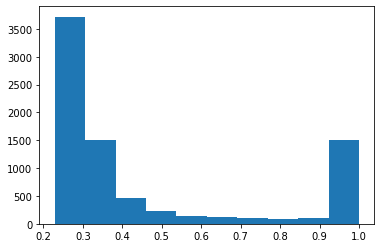

In [23]:
plt.hist(list(submit["target"]))

In [24]:
# submit.to_csv('sub_16_bce_mse.csv', index=False)


In [61]:
best = pd.read_csv("./submission_748.csv")

(array([3494., 1511.,  524.,  235.,  142.,  101.,  107.,  112.,  192.,
        1557.]),
 array([0.05396304, 0.14856674, 0.24317043, 0.33777413, 0.43237783,
        0.52698152, 0.62158522, 0.71618891, 0.81079261, 0.9053963 ,
        1.        ]),
 <BarContainer object of 10 artists>)

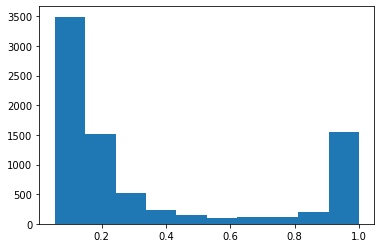

In [62]:
plt.hist(list(best["target"]))

(array([2554., 1077.,  667.,  468.,  356.,  264.,  237.,  205.,  207.,
        1940.]),
 array([0.00189288, 0.10170359, 0.2015143 , 0.30132502, 0.40113573,
        0.50094644, 0.60075715, 0.70056786, 0.80037858, 0.90018929,
        1.        ]),
 <BarContainer object of 10 artists>)

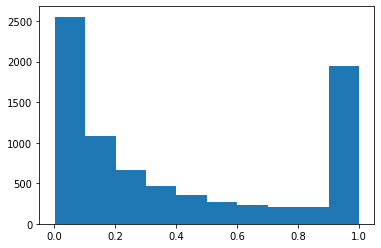

In [101]:
plt.hist(list(submit["target"]))

In [99]:
t = submit["target"] - min(list(submit["target"]))
t = t / max(t)

In [100]:
# plt.hist(abs(t - best["target"]))
import sklearn
sklearn.metrics.auc(sorted(t), sorted(best["target"]))

0.3187378624451336

(array([ 253., 2341., 2224., 1010.,  473.,  265.,  157.,  150.,  188.,
         914.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

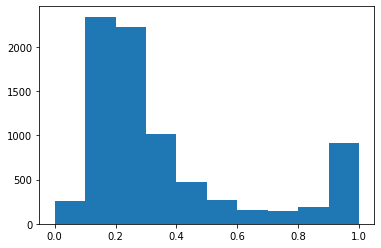

In [97]:
plt.hist(t)

In [51]:
submit["target"] = (submit["target"] * 3 + best["target"] * 7) / 10.0

In [52]:
submit.to_csv('sub_many_folds_30pct.csv', index=False)


In [61]:
# #####
# ##### TTA
# #####

# submit = pd.read_csv('./sample_submission.csv')
# model = Model(model_name, pretrained=False)
# model.to(device);


# filenames = ["model0_120fold0_8400"]

# num_tfms=5

# for i in range(len(filenames)):

#     model = Model(model_name, pretrained=False)
#     ffname = filenames[i]
#     filename = f'./{ffname}.pytorch'
#     model.to(device)
#     model.load_state_dict(torch.load(filename, map_location=device))
#     model.eval()
    
#     for tfmsi in range(num_tfms):
#         dataset_test = Dataset('test', submit, tfms=True)
#         loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
#                                                 num_workers=num_workers, pin_memory=True)

#         test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))
#         submit['target'] += test['y_pred'] / (len(filenames) * num_tfms)


In [62]:
# plt.hist(list(submit["target"]))

In [63]:
# submit.to_csv('submission_120_fold0_TTA.csv', index=False)

In [30]:
file_id = list(os.listdir("./train"))[0].split(".")[0]

IMGSIZE = 180

img = np.zeros((3, 360, IMGSIZE), dtype=np.float32)

filename = '%s/%s.hdf5' % ("train", file_id)
with h5py.File(filename, 'r') as f:
    g = f[file_id]

    h1raw = g["H1"]['SFTs']
    h1across = int(h1raw.shape[1] / IMGSIZE)
    l1raw = g["L1"]['SFTs']
    l1across = int(l1raw.shape[1] / IMGSIZE)
    across = min(h1across, l1across)

    for ch, s in enumerate(['H1', 'L1']):
        a = g[s]['SFTs'][:, :(across*IMGSIZE)] * 1e22  # Fourier coefficient complex64

        areal = a.real**2
        aimag = a.imag**2
        p = areal + aimag  # power
        p /= np.mean(p)  # normalize

        p = np.mean(p.reshape(360, IMGSIZE, across), axis=2)  # compress 4096 -> 128

        img[ch] = p
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


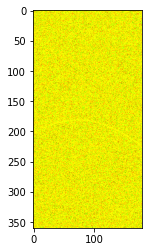

In [32]:
plt.imshow(img.transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


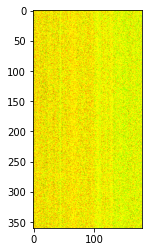

In [86]:
file_id = list(os.listdir("./test"))[4].split(".")[0]

IMGSIZE = 180

img = np.zeros((3, 360, IMGSIZE), dtype=np.float32)

filename = '%s/%s.hdf5' % ("test", file_id)
with h5py.File(filename, 'r') as f:
    g = f[file_id]

    h1raw = g["H1"]['SFTs']
    h1across = int(h1raw.shape[1] / IMGSIZE)
    l1raw = g["L1"]['SFTs']
    l1across = int(l1raw.shape[1] / IMGSIZE)
    across = min(h1across, l1across)

    for ch, s in enumerate(['H1', 'L1']):
        a = g[s]['SFTs'][:, :(across*IMGSIZE)] * 1e22  # Fourier coefficient complex64

        areal = a.real**2
        aimag = a.imag**2
        p = areal + aimag  # power
        p /= np.mean(p)  # normalize

        p = np.mean(p.reshape(360, IMGSIZE, across), axis=2)  # compress 4096 -> 128

        img[ch] = p
        
plt.imshow(img.transpose((1,2,0)))

In [87]:

for i in range(img.shape[2]):
    img[0,:,i] = (img[0,:,i] - np.mean(img[0,:,i])) / np.std(img[0,:,i])
    img[1,:,i] = (img[1,:,i] - np.mean(img[1,:,i])) / np.std(img[1,:,i])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


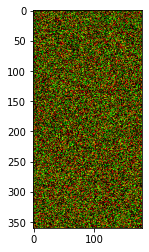

In [88]:
plt.imshow(img.transpose((1,2,0)))

In [ ]:
def json_filename_from_params(signal_v,tstart,f0,h0,f1,alpha,delta,cosi,psi,phi,sqrtSX):
    savefname = [str(int(tstart))]
    for value in [f0,h0,f1,alpha,delta,cosi,psi,phi,sqrtSX * 1e24]:
        savefname.append(str(round(value, 2)))
    savefname = "_".join(savefname) + f"_{signal_v}.json"
    return savefname        


In [35]:
# full_sig_json, new_sig_json2, new_sig_json3 = too low
# new_sig_json, new_sig_json4, new_sig_json5, new_sig_bands2, new_sig_bands3 = also low
# new_sig_bands_weak, better_bands, better_bands_symetric, better_bands_symetric2 = 25 - 60

for folder in ["./full_sig_json", "./new_sig_json", "./new_sig_json2", 
               "./new_sig_json3", "./new_sig_json4", "./new_sig_json5",
              "./new_sig_bands2", "./new_sig_bands3",
              "./new_sig_bands_weak",
              "./better_bands", "./better_bands_symetric", "./better_bands_symetric2"]:
               
    h0s = []
    for f in os.listdir(folder):
        if "json" not in f:
            continue
        h0s.append(float(f.split("_")[2]))
    print(folder, min(h0s), max(h0s))
#     break

./full_sig_json 5.02 49.91
./new_sig_json 9.24 39.97
./new_sig_json2 5.02 39.92
./new_sig_json3 5.0 39.98
./new_sig_json4 9.01 29.92
./new_sig_json5 9.07 59.99
./new_sig_bands2 9.06 39.71
./new_sig_bands3 9.17 39.98
./new_sig_bands_weak 25.02 59.94
better_bands 25.17 59.8
better_bands_symetric 25.01 59.98
better_bands_symetric2 25.02 59.89


In [22]:
b1 = pd.read_csv("sub_only_h010_7b.csv")
b2 = pd.read_csv("sub_only_h015.csv")
b3 = pd.read_csv("sub_big_conv_5folds.csv")
b4 = pd.read_csv("sub_many_folds_30pct.csv")
b5 = pd.read_csv("sub748_plus_5fold.csv")

In [24]:
submit = pd.read_csv('./sample_submission.csv')

In [31]:
submit["target"] = (b1["target"] + b2["target"] + b3["target"] + 2*b4["target"] + 3*b5["target"]) / 8.0

In [33]:
submit

,id,target
0,00054c878,0.191692
1,0007285a3,0.807574
2,00076c5a6,0.180237
3,001349290,0.262190
4,001a52e92,0.416445
...,...,...
7970,ffbce04ef,0.944064
7971,ffc2d976b,0.257886
7972,ffc905909,0.151640
7973,ffe276f3e,0.389391


(array([2415., 2226.,  793.,  340.,  192.,  166.,  149.,  122.,  152.,
        1420.]),
 array([0.11354062, 0.20214715, 0.29075368, 0.37936021, 0.46796675,
        0.55657328, 0.64517981, 0.73378634, 0.82239287, 0.9109994 ,
        0.99960593]),
 <BarContainer object of 10 artists>)

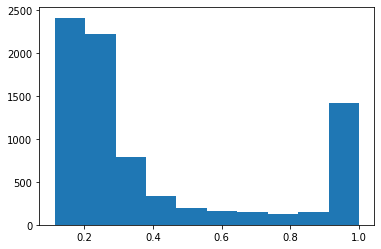

In [34]:
plt.hist(list(submit["target"]))

In [35]:
submit.to_csv('sub_post_7b_combined.csv', index=False)

In [18]:

for folder in ["./unused_so_far"]:
               
    for f in os.listdir(folder):
        if f == ".ipynb_checkpoints" or f == ".DS_Store":
            continue
        h0 = float(f.split("_")[2])
        if h0 < 10:
            continue
        
        df = df.append({"id": folder + "/" + f, "target": f.split(".")[-3].split("_")[-1], "source": "unused"}, ignore_index=True)
print("DONE")


DONE


In [19]:
len(df[df["source"] == "unused"])

6000

In [27]:
model_name = 'tf_efficientnet_b7_ns'
# submit = pd.read_csv('./sample_submission.csv')
model = Model(model_name, pretrained=False)
model.to(device);

filenames = ["model0_16", "model0_16_final"]

targets =[]

for i in range(len(filenames)):
    
    model = Model(model_name, pretrained=False)
    ffname = filenames[i]
    filename = f'./{ffname}.pytorch'
    
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    # Predict
    dataset_test = Dataset('train', df[df["source"] == "unused"], tfms=False)
#     dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                            num_workers=2, pin_memory=True)

    test = evaluate(model, loader_test, compute_score=False, pbar=len(df[df["source"] == "unused"]))
    
    targets.append(test['y_pred'])
    
        # Write prediction
#     if i == 0:
#         submit['target'] = test['y_pred'] / len(filenames)
#     else:
#         submit['target'] += test['y_pred'] / len(filenames)
        
# submit.to_csv('submission.csv', index=False)
# print('target range [%.2f, %.2f]' % (submit['target'].min(), submit['target'].max()))
print("DONE")

DONE


In [40]:
def evaluate2(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)

    for img, freq, mean0, std0, mean1, std1, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)
        freq = freq.to(device)
        mean0 = mean0.to(device)
        std0 = std0.to(device)
        mean1 = mean1.to(device)
        std1 = std1.to(device)

        with torch.no_grad():
#             y_pred = model(img, freq)
            y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred7,y_pred8,y_pred9,y_pred10 = model(img, freq, mean0, std0, mean1, std1)        
            y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6 + y_pred7 + y_pred8 + y_pred9 + y_pred10) / 10.0
        
#         loss = criterion(y_pred[:,0].view(-1), y) + msecriterion(y_pred[:,1].view(-1).sigmoid(), y)

        n_sum += n
#         loss_sum += n * loss.item()

        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred.cpu().detach().numpy())
#         y_pred_all.append(y_pred[:,0].sigmoid().squeeze().cpu().detach().numpy())
#         y_pred_all.append(y_pred.squeeze().cpu().detach().numpy())

        if pbar is not None:
            pbar.update(len(img))
        
        del y_pred, img, y

#     loss_val = loss_sum / n_sum

#     if compute_score:
#         if y_pred_all[0].size != y_pred_all[-1].size:
#             y_pred_all = y_pred_all[:-2]
#             y_all = y_all[:-2]
    
    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

#     score = roc_auc_score(y, y_pred) if compute_score else None

    ret = {'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary

    return ret

In [41]:
model_name = 'tf_efficientnet_b7_ns'
# submit = pd.read_csv('./sample_submission.csv')
model = Model(model_name, pretrained=False)
model.to(device);

filenames = ["model0_16", "model0_16_final"]

full_targets =[]

for i in range(len(filenames)):
    
    model = Model(model_name, pretrained=False)
    ffname = filenames[i]
    filename = f'./{ffname}.pytorch'
    
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.fc[4] = torch.nn.Identity()
    model.eval()

    # Predict
    dataset_test = Dataset('train', df[df["source"] == "unused"], tfms=False)
#     dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                            num_workers=2, pin_memory=True)

    test = evaluate2(model, loader_test, compute_score=False, pbar=len(df[df["source"] == "unused"]))
    
    full_targets.append(test['y_pred'])
    
print("DONE")

DONE


In [44]:
full_targets[0][0].shape

(256,)

In [50]:
np.save("./unused_so_far_targets/16_targets.npy", np.array(targets))

In [51]:
np.save("./unused_so_far_targets/16_full_targets.npy", np.array(full_targets))

In [10]:
bestsub = pd.read_csv("./sub748_plus_5fold.csv")
for rowi, row in bestsub.iterrows():
    df = df.append({"id": row["id"], 
                    "target": 1, 
                    "source": "test"}, ignore_index=True)

In [11]:
len(df[df["source"] == "test"])

7975

In [12]:
model_name = 'tf_efficientnet_b7_ns'
# submit = pd.read_csv('./sample_submission.csv')
model = Model(model_name, pretrained=False)
model.to(device);

filenames = ["model0_16", "model0_16_final"]

targets =[]

for i in range(len(filenames)):
    
    model = Model(model_name, pretrained=False)
    ffname = filenames[i]
    filename = f'./{ffname}.pytorch'
    
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    # Predict
    dataset_test = Dataset('train', df[df["source"] == "test"], tfms=False)
#     dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                            num_workers=2, pin_memory=True)

    test = evaluate(model, loader_test, compute_score=False, pbar=len(df[df["source"] == "test"]))
    
    targets.append(test['y_pred'])
print("DONE")


DONE


In [13]:
print(len(targets), len(targets[0]), targets[0][0])

2 7975 0.32422236


In [14]:
model.fc

Sequential(
  (0): Linear(in_features=2563, out_features=512, bias=True)
  (1): GELU(approximate=none)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): GELU(approximate=none)
  (4): Linear(in_features=256, out_features=2, bias=True)
)

In [15]:
def evaluate2(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)

    for img, freq, mean0, std0, mean1, std1, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)
        freq = freq.to(device)
        mean0 = mean0.to(device)
        std0 = std0.to(device)
        mean1 = mean1.to(device)
        std1 = std1.to(device)

        with torch.no_grad():
#             y_pred = model(img, freq)
            y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6,y_pred7,y_pred8,y_pred9,y_pred10 = model(img, freq, mean0, std0, mean1, std1)        
            y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6 + y_pred7 + y_pred8 + y_pred9 + y_pred10) / 10.0

        n_sum += n

        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred.cpu().detach().numpy())

        if pbar is not None:
            pbar.update(len(img))
        
        del y_pred, img, y
        
    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    ret = {'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary

    return ret

In [16]:
model_name = 'tf_efficientnet_b7_ns'
# submit = pd.read_csv('./sample_submission.csv')
model = Model(model_name, pretrained=False)
model.to(device);

filenames = ["model0_16", "model0_16_final"]

full_targets =[]

for i in range(len(filenames)):
    
    model = Model(model_name, pretrained=False)
    ffname = filenames[i]
    filename = f'./{ffname}.pytorch'
    
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.fc[4] = torch.nn.Identity()
    model.eval()

    # Predict
    dataset_test = Dataset('train', df[df["source"] == "test"], tfms=False)
#     dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                            num_workers=2, pin_memory=True)

    test = evaluate2(model, loader_test, compute_score=False, pbar=len(df[df["source"] == "test"]))
    
    full_targets.append(test['y_pred'])
    
print("DONE")

DONE


In [17]:
full_targets[0].shape

(7975, 256)

In [18]:
full_targets[0][0].shape

(256,)

In [19]:

np.save("./unused_so_far_targets/16_test_targets.npy", np.array(targets))
np.save("./unused_so_far_targets/16_test_full_targets.npy", np.array(full_targets))
